### Deep Fine-Scale Prediction

In [95]:
import os
import copy
import torch
import torch.utils.data as dat
import torch.nn as nn
import torch.nn.functional as F
from tensorboardX import SummaryWriter
from torch.autograd import Variable
from tensorboardX import SummaryWriter
import torch.optim as optim
import argparse
import numpy as np
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')


### Program Settings

In [96]:
# parser = argparse.ArgumentParser()

# parser.add_argument('--data_filename', type=str, default=)
# parser.add_argument('--mapping_mat_filename', type=str, default='./data/data/los_angeles_1000m_grid_mat.npz')
# parser.add_argument('--model_dir', type=str, default='./data/model/')
# parser.add_argument('--log_dir', type=str, default='./data/runs/')

# parser.add_argument('--area', type=str, default='los_angeles')
# parser.add_argument('--resolution', type=int, default=1000)
# parser.add_argument('--cur_time', type=str, default=datetime.now().strftime('%m%d%H'))
# parser.add_argument('--seq_len', type=int, default=12)

# args = parser.parse_args()

# ============================================================================================================ #

data_filename = './data/data/los_angeles_500m_data.npz'
mapping_mat_filename = './data/data/los_angeles_500m_grid_mat.npz'
model_dir = './data/models/'
log_dir = './data/runs/'

area = 'los_angeles'  # the name of the area
resolution = 500  # the resolution of the grid, e.g., 500m, 1000m
cur_time = datetime.now().strftime('%m%d%H')  # the current time to represent a unique model
seq_len = 12  # the number of previous time points to take in the LSTM model
device = torch.device("cuda:3" if torch.cuda.is_available() else 'cpu')  # the gpu device

train_val_test = {
    ('los_angeles', 500): {
        'val_loc': sorted([118, 603, 861, 958, 2114, 2228, 3137, 3470, 3569, 3742, 4085, 4270, 4492, 4501, 4797, 
                           4810, 5058, 5103, 5178, 5590, 5832, 5881, 6153, 6431, 6601, 6748, 6907, 6988]),
        'test_loc': sorted([669, 864, 953, 1321, 1423, 1735, 2312, 2833, 3486, 3562, 3711, 3777, 3898, 4081, 4342, 
                            4720, 4723, 4795, 4945, 5094, 5600, 5694, 5695, 5729, 5771, 5847, 5984, 6265, 6356, 6912])
    },
    ('los_angeles', 1000): {
        'val_loc': sorted([21, 249, 282, 545, 562, 657, 774, 869, 902, 911, 1052, 1069, 1182, 1183, 1226, 1233, 
                           1269, 1341, 1375, 1399, 1441, 1510, 1556, 1557, 1577]),
        'test_loc': sorted([150, 183, 251, 432, 586, 587, 737, 961, 976, 1014, 1017, 1093, 1145, 1220, 1255, 1256, 
                            1297, 1338, 1404, 1422, 1475, 1480, 1537, 1620, 1667, 1703, 1705])
    }
}


### Step 1 - Loading Data

In [97]:

""" load mapping matrix """ 
mapping_mat = np.load(mapping_mat_filename)['mat']

""" load data """ 
data = np.load(data_filename)
feature_mat = data['feature_mat']
label_mat = data['label_mat']
feature_distribution = list(data['feature_distribution'])
pm_grids = list(data['pm_grids'])
grids = list(data['grids'])

val_loc = train_val_test[(area, resolution)]['val_loc']
test_loc = train_val_test[(area, resolution)]['test_loc']
train_loc = sorted([loc for loc in pm_grids if loc not in test_loc + val_loc])

print('Number of pm locations = {}.'.format(len(pm_grids)))
print('Number of training locations = {}.'.format(len(train_loc)))
print('Number of validation locations = {}.'.format(len(val_loc)))
print('Number of testing locations = {}.'.format(len(test_loc)))

# ============================================================================================================ #

def gen_train_val_test_data(label_mat, locations, mapping_mat):

    new_label_mat = np.full(label_mat.shape, np.nan)
    for loc in locations:
        r, c = np.where(mapping_mat == loc)
        new_label_mat[..., r[0], c[0]] = label_mat[..., r[0], c[0]]
    return new_label_mat

train_y = gen_train_val_test_data(label_mat, train_loc, mapping_mat)
val_y = gen_train_val_test_data(label_mat, val_loc, mapping_mat)
test_y = gen_train_val_test_data(label_mat, test_loc, mapping_mat)

n_times, _, global_n_rows, global_n_cols = train_y.shape
print('Number of times = {}.'.format(n_times))
print('Shape of the matrix = ({}, {}).'.format(global_n_rows, global_n_cols))

n_features = sum(feature_distribution)
print('Number of features = {}.'.format(n_features))
n_dynamic_features = sum(feature_distribution[:2])
print('Number of dynamic features = {}.'.format(n_dynamic_features))
n_static_features = feature_distribution[-1]
print('Number of static features = {}.'.format(n_static_features))


Number of pm locations = 138.
Number of training locations = 80.
Number of validation locations = 28.
Number of testing locations = 30.
Number of times = 624.
Shape of the matrix = (92, 76).
Number of features = 93.
Number of dynamic features = 11.
Number of static features = 82.


In [98]:

""" normalize the input feature matrix
    
Params:
    feature_mat: (n_times, n_features, n_rows, n_cols)
Return:
    norm_mat: (n_times, n_features, n_rows, n_cols)
"""

class Norm:

    def __init__(self, x):
        self.mean = np.nanmean(x, axis=0)
        self.std = np.nanstd(x, axis=0)

    def transform(self, x):
        return np.divide(x - self.mean, self.std, out=np.zeros_like(x - self.mean), where=self.std != 0.0)


x_2d = np.moveaxis(feature_mat, 1, -1) #  => (n_times, n_rows, n_cols, n_features)
x_2d = x_2d.reshape(-1, x_2d.shape[-1])  #  => (n_samples, n_features)
norm = Norm(x_2d)
norm_mat = norm.transform(x_2d)

norm_mat = norm_mat.reshape(n_times, global_n_rows, global_n_cols, -1)  
norm_mat = np.moveaxis(norm_mat, -1, 1)  

print(norm_mat.shape)  
# (624, 93, 92, 76)


(624, 93, 92, 76)


### Step 2 - Pre-Train Auto-Encoder

In [99]:

""" construct data loader for auto-encoder
    
params:  
    input_x: (n_times, n_features, n_rows, n_cols)
    ae_data_loader: data loader of the input to the auto-encoder
    
"""

BATCH_SIZE = 4

input_x = norm_mat
input_x = np.moveaxis(input_x, 1, -1)  # (624, 92, 76, 91)

ae_dataset = dat.TensorDataset(torch.FloatTensor(input_x))
ae_data_loader = dat.DataLoader(dataset=ae_dataset, batch_size=BATCH_SIZE, shuffle=True)


In [100]:
from models.auto_encoder import AutoEncoder

""" define the auto-encoder """

ae_params = {
    'in_dim': n_static_features + n_dynamic_features, # n_all_features, # n_static_features,
    'en_h_dims': [64, 32, 16], 
    'de_h_dims': [16, 32, 64]
}

ae = AutoEncoder(in_dim=ae_params['in_dim'], 
                 en_h_dims=ae_params['en_h_dims'], 
                 de_h_dims=ae_params['de_h_dims']).to(device)
print(ae)


AutoEncoder(
  (in_layer): Linear(in_features=93, out_features=64, bias=True)
  (encoder): ModuleList(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=16, bias=True)
  )
  (decoder): ModuleList(
    (0): Linear(in_features=16, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=64, bias=True)
  )
  (out_layer): Linear(in_features=64, out_features=93, bias=True)
)


In [83]:

EPOCHS = 100
LEARNING_RATE = 0.01

ae_model_name = 'ae_{}_{}m_{}'.format(area, resolution, cur_time)
ae_model_path = os.path.join(model_dir, ae_model_name + '.pkl')
ae_log_path = os.path.join(log_dir, ae_model_name + '_log')

writer = SummaryWriter(ae_log_path)
loss_func = nn.MSELoss()
optimizer = optim.SGD(ae.parameters(), lr=LEARNING_RATE, momentum=0.9)

print('>>> {}: Training process has started.'.format(ae_model_name))

for epoch in range(EPOCHS):
    
    train_losses = []
    for i, data in enumerate(ae_data_loader):
        
        x = data[0].to(device)
        _, de_x = ae(x)
        loss = loss_func(x, de_x)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        train_losses.append(loss.item())
        
    avg_loss = sum(train_losses) / len(train_losses)
    writer.add_scalar('data/{}_loss'.format(ae_model_name), avg_loss, epoch)

    if epoch % 10 == 0:
        print('Epoch [{}/{}], Loss = {}.'.format(epoch, EPOCHS, avg_loss))

print('>>> {}: Training process has finished.'.format(ae_model_name))

torch.save(ae, ae_model_path)
print('>>> {} has been saved.'.format(ae_model_name))


>>> ae_los_angeles_500m_100707: Training process has started.
Epoch [0/100], Loss = 1.0050274515763307.
Epoch [10/100], Loss = 0.9963750567955848.
Epoch [20/100], Loss = 0.9136667839991741.
Epoch [30/100], Loss = 0.8164591368956443.
Epoch [40/100], Loss = 0.7174438562912818.
Epoch [50/100], Loss = 0.5782194798573469.
Epoch [60/100], Loss = 0.453278087079525.
Epoch [70/100], Loss = 0.3866984420097791.
Epoch [80/100], Loss = 0.345795788252965.
Epoch [90/100], Loss = 0.32124611219534505.
>>> ae_los_angeles_500m_100707: Training process has finished.
>>> ae_los_angeles_500m_100707 has been saved.


### Step 3 - Train Deep Fine-Scale Prediction Model

In [101]:

""" construct data loader for training
    
Params:
    input_x: (n_times, n_features, n_rows, n_cols)
    train_data_loader: data loader of the input 
    
"""

BATCH_SIZE = 2

input_x = norm_mat

# log the output values
new_train_y = train_y # (624, 1, 92, 76)
new_val_y = val_y # (624, 1, 92, 76)
new_test_y = test_y # (624, 1, 92, 76)

train_idx = np.array([i for i in range(seq_len, n_times)])
print(train_idx.shape)

train_dataset = dat.TensorDataset(torch.IntTensor(train_idx))
train_data_loader = dat.DataLoader(dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True)

test_dataset = dat.TensorDataset(torch.IntTensor(train_idx))
test_data_loader = dat.DataLoader(dataset=test_dataset, batch_size=1, shuffle=False)


(612,)


In [102]:
from models.conv_lstm import ConvLSTM
from models.regr_net import RegrNet
from models.auto_encoder import AutoEncoder
from models.mask_net import MaskNet


class SPEC(nn.Module):

    def __init__(self, in_dim, ae_en_h_dims, ae_de_h_dims, 
                 conv_lstm_in_size, conv_lstm_in_dim, conv_lstm_h_dim, conv_lstm_kernel_sizes, conv_lstm_n_layers, 
                 fc_in_dim, fc_h_dims, fc_out_dim, **kwargs):
        
        super(SPEC, self).__init__()

        self.device = kwargs.get('device', 'cpu')
        
        ################
        # masked layer #
        ################
        
        mask = [[i for i in range(in_dim)], [i for i in range(in_dim)]]  
        self.mask_layer = MaskNet(in_dim, in_dim, mask, device=self.device)
        self.mask_thre = kwargs.get('mask_thre', 0.0001)
        
        ######################
        # auto_encoder layer #
        ######################
        
        self.ae = AutoEncoder(in_dim=in_dim, 
                              en_h_dims=ae_en_h_dims, 
                              de_h_dims=ae_de_h_dims)
        
        if kwargs.get('ae_pretrain_weight') is not None:
            self.ae.load_state_dict(kwargs['ae_pretrain_weight'])
        else:
            raise ValueError('AutoEncoder not pretrained.')

        if kwargs.get('if_trainable'):
            for p in self.ae.parameters():
                p.requires_grad = kwargs['if_trainable']
        else:
            self.ae.weight.requires_grad = False
    
        ####################
        # conv_lstm layers #
        ####################
        
        self.conv_lstm_list = nn.ModuleList()
        for i in conv_lstm_kernel_sizes:
            i_kernel_size = (i, i)
            conv_lstm = ConvLSTM(in_size=conv_lstm_in_size, 
                                 in_dim=conv_lstm_in_dim,
                                 h_dim=conv_lstm_h_dim,
                                 kernel_size=i_kernel_size,
                                 num_layers=conv_lstm_n_layers,
                                 batch_first=kwargs.get('conv_lstm_batch_first', True),
                                 bias=kwargs.get('conv_lstm_bias', True),
                                 only_last_state=kwargs.get('only_last_state', True),
                                 device=self.device)
            self.conv_lstm_list.append(conv_lstm)
               
        #########################
        # fully-connected layer #
        #########################
        
        self.fc = RegrNet(in_dim=fc_in_dim, # assert in_size == n_conv_lstm * conv_lstm_h_dim
                          h_dims=fc_h_dims,
                          out_dim=fc_out_dim,
                          p_dropout=kwargs.get('fc_p_dropout', 0.0))

    def forward(self, input_data):  # input_data: (b, t, c, h, w)
        
        static_x = input_data[:, :, n_dynamic_features: , :, :]  # (b, t, c, h, w)
        dynamic_x = input_data[:, :, : n_dynamic_features, :, :]  # (b, t, c, h, w)
        
        x = input_data.permute(0, 1, 3, 4, 2)  # => (b, t, h, w, c) 
 
        ################
        # masked layer #
        ################
        
        masked_x = self.mask_layer(x)
        
        for p in self.mask_layer.parameters():
            for i in range(p.size(1)):
                if -self.mask_thre <= p[i, i] <= self.mask_thre:
                    masked_x[..., i] = 0.0
       
        ######################
        # auto-encoder layer #
        ######################
        
        en_x, de_x = self.ae(masked_x)
        en_x = en_x.permute(0, 1, 4, 2, 3)  # => (b, t, c, h, w)
        
        ######################
        # conv_lstm layers #
        ######################
        
        conv_lstm_out_list = []
        for conv_lstm in self.conv_lstm_list:
            conv_lstm_last_hidden, conv_lstm_last_state = conv_lstm(en_x)
            _, cell_last_state = conv_lstm_last_state
            conv_lstm_out_list.append(cell_last_state)
            
        conv_lstm_out = torch.cat(conv_lstm_out_list, dim=1)
 
        ###########################
        # fully-connected layer #
        ###########################
     
        fc_out = conv_lstm_out.permute(0, 2, 3, 1)  # => (b, h, w, c)
        fc_out = self.fc(fc_out)
        fc_out = fc_out.permute(0, 3, 1, 2)  # => (b, c, h, w)
        
        return fc_out, masked_x, de_x


In [103]:

""" define SPEC model """

# load auto-encoder model
ae_model_name = 'ae_los_angeles_500m_100707'
ae = torch.load(os.path.join(model_dir, ae_model_name + '.pkl'))

spec = SPEC(in_dim=n_static_features + n_dynamic_features, 
            ae_en_h_dims=[64, 32, 16], 
            ae_de_h_dims=[16, 32, 64], 
                              
            conv_lstm_in_size=(global_n_rows, global_n_cols), 
            conv_lstm_in_dim=16,  # encoded tensor 
            conv_lstm_h_dim=[32], 
            conv_lstm_kernel_sizes=[1, 3, 5], 
            conv_lstm_n_layers=1, 

            fc_in_dim=32*3, 
            fc_h_dims=[64, 16], 
            fc_out_dim=1,
                             
            ae_pretrain_weight=ae.state_dict(),
            if_trainable=True,
            fc_p_dropout=0.1,
                    
            device=device)

spec = spec.to(device)
spec_model_name = 'spec_{}_{}m_{}_{}'.format(area, resolution, seq_len, cur_time)
# spec_model_name = 'spec_los_angeles_1000_12_100704'


In [87]:
from utils.early_stopping import EarlyStopping
from utils.evaluations import compute_error

EPOCHS = 150
LEARNING_RATE = 0.001

spec_model_name = 'spec_{}_{}_{}_{}'.format(area, resolution, seq_len, cur_time)
# spec_model_name = 'spec_los_angeles_1000_12_100704'
spec_model_path = os.path.join(model_dir, spec_model_name + '.pkl')
spec_log_path = os.path.join(log_dir, spec_model_name + '_log')

writer = SummaryWriter(spec_log_path)
loss_func = nn.MSELoss()
optimizer = optim.Adam(spec.parameters(), lr=LEARNING_RATE)
early_stopping = EarlyStopping(patience=7, verbose=True)


def spatial_neighbor_loss(mat, n_step=1):
        
    loss = 0.0
    
    # left-up & right-down
    loss += loss_func(mat[..., :-n_step, :-n_step], mat[..., n_step:, n_step:]) / 1.4 * 2
    
    # up & down
    loss += loss_func(mat[..., :-n_step, :], mat[..., n_step:, :]) * 2
    
    # right-up & left-down
    loss += loss_func(mat[..., :-n_step, n_step:], mat[..., n_step:, :-n_step]) / 1.4 * 2
    
    # left & right
    loss += loss_func(mat[..., :, :-n_step], mat[..., :, n_step:]) * 2
    
    return loss / 8


for epoch in range(EPOCHS):
    
    spec.train()
    total_losses, train_losses, val_losses = [], [], []

    for i, data in enumerate(train_data_loader):
        
        batch_idx = data[0]    
        
        ############################
        # construct sequence input #
        ############################
        
        def construct_sequence_x(idx_list):
            x = []
            for idx in idx_list:
                x.append(input_x[idx - seq_len : idx + 1, ...])
            return x

        def construct_y(idx_list, output_y):
            y = []
            for idx in idx_list:
                y.append(output_y[idx])
            return y

        batch_x = construct_sequence_x(batch_idx)
        batch_x = np.stack(batch_x, axis=0)   
        batch_x = torch.FloatTensor(batch_x).to(device)  # x = (b, t, c, h, w)
        
        batch_y = construct_y(batch_idx, new_train_y)
        batch_y = np.stack(batch_y, axis=0)   
        batch_y = torch.FloatTensor(batch_y).to(device)  # y = (b, c, h, w)
        
        batch_val_y = construct_y(batch_idx, new_val_y)
        batch_val_y = np.stack(batch_val_y, axis=0)   
        batch_val_y = torch.FloatTensor(batch_val_y).to(device)  # y = (b, c, h, w)
        
        ###################
        # train the model #
        ###################
        
        out, masked_x, de_x = spec(batch_x)
        sp_loss = spatial_neighbor_loss(out)
        mask_layer_params = torch.cat([x.view(-1) for x in spec.mask_layer.parameters()])
        l1_regularization = torch.norm(mask_layer_params, 1)
        ae_loss = loss_func(masked_x, de_x)
            
        loss = loss_func(batch_y[~torch.isnan(batch_y)], out[~torch.isnan(batch_y)])
        train_losses.append(loss.item())

        loss = loss + ae_loss * 10 + l1_regularization * 5 + sp_loss
        total_losses.append(loss.item())
    
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        ######################    
        # validate the model #
        ######################
        
        val_loss = loss_func(batch_val_y[~torch.isnan(batch_val_y)], out[~torch.isnan(batch_val_y)])
        val_losses.append(val_loss.item())
    
    avg_total_losses = np.average(total_losses)
    avg_train_loss = np.average(train_losses)
    avg_val_loss = np.average(val_losses)

    writer.add_scalar('data/{}_loss'.format(spec_model_name), avg_total_losses, epoch)
    
    if epoch % 1 == 0:
        print('Epoch [{}/{}] total_loss = {}, train_loss = {}, valid_loss = {}'.format(epoch, EPOCHS, avg_total_losses, avg_train_loss, avg_val_loss)) 
    
    ##################  
    # early_stopping #
    ##################
    
    early_stopping(avg_val_loss, spec, spec_model_path)        
        
    #########################    
    # evaluate testing data #
    #########################
  
    if early_stopping.counter == 0 and epoch % 2 == 0:

        spec.eval() 
        predictions = []

        with torch.no_grad():                   
            for i, data in enumerate(test_data_loader):
                batch_idx = data[0]
                batch_x = construct_sequence_x(batch_idx)
                batch_x = np.stack(batch_x, axis=0)   
                batch_x = torch.FloatTensor(batch_x).to(device)  # x = (b, t, c, h, w)
                out, _, _ = spec(batch_x)
                predictions.append(out.cpu().data.numpy())

        predictions = np.concatenate(predictions)    
        rmse, r2 = compute_error(new_test_y[seq_len:, ...], predictions)
        print('Overall Error : RMSE = {}, R2 = {}'.format(rmse, r2))
        
    if early_stopping.early_stop:
        print("Early stopping")
        break
    

Epoch [0/150] total_loss = 756.3720900342355, train_loss = 740.3025368085873, valid_loss = 773.1473480798061
Validation loss decreased (inf --> 773.147348).  Saving model to ./data/models/spec_los_angeles_500_12_100707.pkl...
Overall Error : RMSE = 25.214623697511737, R2 = 0.1635215441870569
Epoch [1/150] total_loss = 478.086711546954, train_loss = 454.933617688472, valid_loss = 482.08526208665637
Validation loss decreased (773.147348 --> 482.085262).  Saving model to ./data/models/spec_los_angeles_500_12_100707.pkl...
Epoch [2/150] total_loss = 423.16060616611657, train_loss = 399.1633308198717, valid_loss = 425.7289897943634
Validation loss decreased (482.085262 --> 425.728990).  Saving model to ./data/models/spec_los_angeles_500_12_100707.pkl...
Overall Error : RMSE = 19.51963927474316, R2 = 0.4987050232915522
Epoch [3/150] total_loss = 422.19443374833253, train_loss = 397.47610612009083, valid_loss = 430.7359709147534
Current earlyStopping counter: 1 / 7
Epoch [4/150] total_loss = 

### Step 4 - Evaluation 

In [88]:
# print out the selected features

params = [p for p in spec.mask_layer.linear_layer.parameters()]

weights = []
weight = params[0].data.cpu().numpy()
for i in range(weight.shape[0]):
    weights.append(weight[i, i])

data = np.load(data_filename)
features = ['temperature', 'dew_point', 'humidity', 'pressure', 'wind_speed', 'wind_direction', 'cloud_cover', 
            'visibility', 'hourofday', 'dayofweek', 'day'] + list(data['geo_name'])

for i, w in enumerate(weights):
    if abs(w) > 0.0001:
        print(features[i],  abs(w))
    

dew_point 0.11073457
humidity 0.1055818
wind_direction 0.07997462
cloud_cover 0.11067123
visibility 0.19751875
day 0.14107569
railways_light_rail 0.025275277
roads_pedestrian 0.0098405825
roads_primary 0.020116132
roads_steps 0.017505638
traffic_motorway_junction 0.011460193
traffic_stop 0.021733887
lat 0.11843962


In [89]:
from utils.evaluations import *

spec.eval() 
predictions = []

with torch.no_grad():      
    for i, data in enumerate(test_data_loader):
        batch_idx = data[0]
        batch_x = construct_sequence_x(batch_idx)
        batch_x = np.stack(batch_x, axis=0)   
        batch_x = torch.FloatTensor(batch_x).to(device)  # x = (b, t, c, h, w)
        out, _, _ = spec(batch_x)
        predictions.append(out.cpu().data.numpy())

predictions = np.concatenate(predictions)    
rmse, r2 = compute_error(new_test_y[seq_len:, ...], predictions)
print('Overall Error : RMSE = {}, R2 = {}'.format(rmse, r2))
    

Overall Error : RMSE = 9.696615969799788, R2 = 0.8762941694718008


### Step 5 - Visualization

In [90]:
print(predictions.shape)
print(mapping_mat.shape)

(612, 1, 92, 76)
(92, 76)


In [91]:
import pandas as pd 

time_idx = 62
test_time = time_idx - seq_len

mapping_mat_copy = mapping_mat.reshape(1, mapping_mat.shape[0], mapping_mat.shape[1])
predictions_with_location = np.vstack([predictions[test_time, ...], mapping_mat_copy])
predictions_with_location = predictions_with_location.reshape(2, -1)
predictions_with_location = np.moveaxis(predictions_with_location, -1, 0)
pred_df = pd.DataFrame(predictions_with_location, columns=['pred', 'gid'])
pred_df['gid'] = pred_df['gid'].astype(int)


In [92]:
from geoalchemy2.functions import ST_AsText

geom_df = pd.read_csv('./data/data/{}_{}m_grid.csv'.format(area, resolution))
pred_df = pred_df.merge(geom_df, on='gid')
pred_df.to_csv('./data/results/spec_{}_{}_predictions_{}.csv'.format(area, resolution, time_idx))


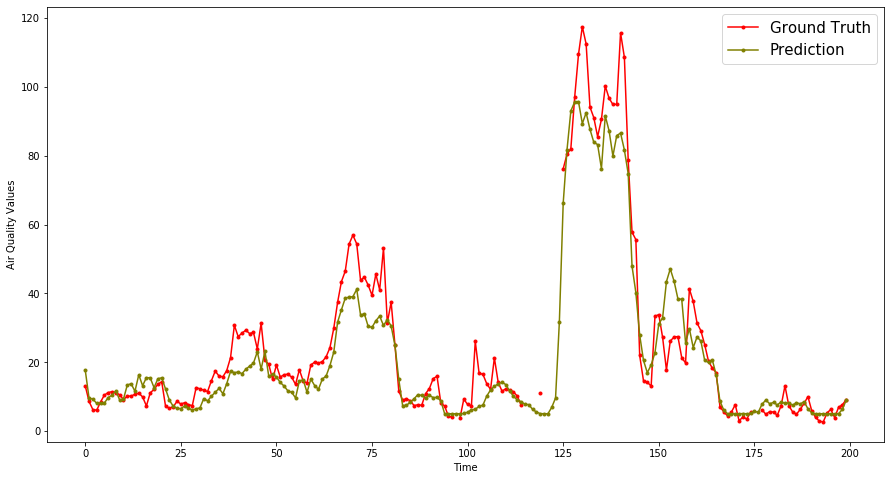

In [94]:
from utils.plottings import *

start_id = 0
end_id = 200

loc_index_r, loc_index_c = np.where(mapping_mat == test_loc[2])
plot_time_series_comparison(test_y[seq_len:, ...][..., loc_index_r[0], loc_index_c[0]][start_id:end_id, 0], 
                            predictions[..., loc_index_r[0], loc_index_c[0]][start_id:end_id, 0], 
                            [i for i in range(start_id, end_id)])
